# *Credit Risk Modeling with Logistic Regression, Random Forest, and XGBoost*

## This project demonstrates a full end-to-end **binary classification pipeline** for credit risk assessment.  
## It covers all main steps of a data science workflow:

1. **ETL & Data Cleaning**: remove duplicates, handle missing values, prepare numerical and categorical features.  
2. **Preprocessing & Sampling**: median/mode imputation, scaling, one-hot encoding, and oversampling with RandomOverSampler.  
3. **Modeling**: compare three popular classifiers "Logistic Regression, Random Forest, and XGBoost".  
4. **Hyperparameter Tuning**: use RandomizedSearchCV with PR-AUC scoring.  
5. **Evaluation**: PR/ROC curves, confusion matrices, and F1-based threshold optimization.   
6. **Deployment**: export final pipeline.  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Splits & CV
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Metrics
from sklearn.metrics import (average_precision_score, roc_auc_score, f1_score,precision_recall_curve, roc_curve, confusion_matrix, classification_report)

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Oversampling 
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Save artifacts
import joblib

# Reproducibility
np.random.seed(42)
print("Setup complete.")


Setup complete.


In [2]:
# Loading the dataset 
CSV_PATH = r"C:\Users\asus iultra 9 2024\Downloads\incom data csv.csv"

data = pd.read_csv(CSV_PATH, sep=";")
print("Shape:", data.shape)
data.head()


Shape: (32581, 12)


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,Unnamed: 10,cb_person_default_on_file
0,22,59000,RENT,123.0,PERSONAL,35000,16.02,1,0.59,3,NaN,Y
1,21,9600,OWN,5.0,EDUCATION,1000,11.14,0,0.10,2,NaN,N
2,25,9600,MORTGAGE,1.0,MEDICAL,5500,12.87,1,0.57,3,NaN,N
3,23,65500,RENT,4.0,MEDICAL,35000,15.23,1,0.53,2,NaN,N
4,24,54400,RENT,8.0,MEDICAL,35000,14.27,1,0.55,4,NaN,Y


In [4]:
# Quick structure to see dtypes and non-null counts 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_amnt                   32581 non-null  int64  
 6   loan_int_rate               29465 non-null  float64
 7   loan_status                 32581 non-null  int64  
 8   loan_percent_income         32581 non-null  float64
 9   cb_person_cred_hist_length  32581 non-null  int64  
 10  Unnamed: 10                 0 non-null      float64
 11  cb_person_default_on_file   32581 non-null  object 
dtypes: float64(4), int64(5), object(3)
memory usage: 3.0+ MB


In [5]:
# Copy to working dataframe
df = data.copy()

In [6]:
# Remove "Unnamed:*" columns that often appear from CSV exports
unnamed = [c for c in df.columns if c.lower().startswith("unnamed")]
df = df.drop(columns=unnamed, errors="ignore")

In [7]:
# Remove exact duplicate rows
before = len(df)
df = df.drop_duplicates().reset_index(drop=True)
removed = before - len(df)
print(f"Removed duplicates: {removed}")

Removed duplicates: 165


In [8]:
df.head(3)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,cb_person_default_on_file
0,22,59000,RENT,123.0,PERSONAL,35000,16.02,1,0.59,3,Y
1,21,9600,OWN,5.0,EDUCATION,1000,11.14,0,0.10,2,N
2,25,9600,MORTGAGE,1.0,MEDICAL,5500,12.87,1,0.57,3,N


## Data Cleaning (ETL)

- Dropped accidental `Unnamed:*` columns created during CSV export.  
- Removed exact duplicate rows.  
- Verified class balance: the dataset shows an **imbalanced distribution** of target classes.  

This motivates the use of **oversampling (ROS)** in all model pipelines.

In [9]:
# target column 
target = "loan_status"

In [10]:
# Drop rows with missing target
df = df[~df[target].isna()].copy()

In [11]:
# Split into X/y
X = df.drop(columns=[target])
y = df[target].astype(int)

In [12]:
# Identify numeric and categorical features
num_cols = X.select_dtypes(include=["number"]).columns.tolist()
cat_cols = X.select_dtypes(exclude=["number"]).columns.tolist()

print(f"Rows: {len(df)} | Features: {X.shape[1]}  (num={len(num_cols)}, cat={len(cat_cols)})")

Rows: 32416 | Features: 10  (num=7, cat=3)


Class balance: {0: 0.7813116979269497, 1: 0.21868830207305034}


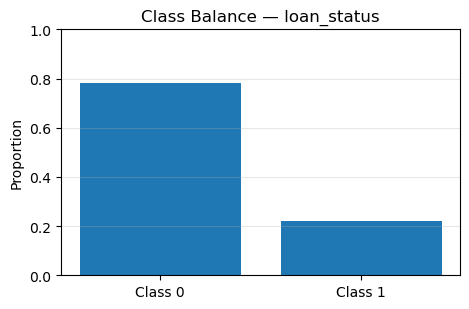

In [13]:
# Quick check of class balance 
rates = y.value_counts(normalize=True).sort_index()
print("Class balance:", rates.to_dict())

plt.figure(figsize=(4.8,3.2))
plt.bar(["Class 0","Class 1"], rates.values)
plt.title("Class Balance — loan_status")
plt.ylabel("Proportion")
plt.ylim(0,1)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

In [14]:
# Keeping a clean holdout (TEST), and a VALID set for threshold tuning 
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.20, stratify=y_train_full, random_state=42)

In [15]:
# OneHotEncoder across sklearn versions, always ignore unknown categories at inference 
def make_ohe():
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=False)

In [16]:
# Numeric pipeline: median imputation + standard scale
num_prep = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler())])

In [17]:
# Categorical pipeline: most-frequent imputation + OHE
cat_prep = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("ohe", make_ohe())])

In [19]:
# ColumnTransformer to apply the right preprocessing to each block of columns
preprocess = ColumnTransformer(
    transformers=[
        ("num", num_prep, num_cols),
        ("cat", cat_prep, cat_cols),],
    remainder="drop")

In [23]:
# Applying RandomOverSampler inside the pipeline 
def make_pipe_with_ros(preprocess, clf):
    return ImbPipeline(steps=[
        ("prep", preprocess),                         # impute + encode + scale
        ("ros", RandomOverSampler(random_state=42)),  # oversample minority class on TRAIN folds only
        ("clf", clf)])                                # the classifier


## Preprocessing Setup

- **Numeric features**: median imputation → standard scaling.  
- **Categorical features**: most-frequent imputation → one-hot encoding.  

This preprocessing is wrapped inside a `ColumnTransformer`, ensuring consistent treatment across models.

In [24]:
# Logistic Regression 
lr = LogisticRegression(max_iter=2000, solver="lbfgs", class_weight=None)

In [25]:
# Wrap in pipeline with ROS
lr_pipe = make_pipe_with_ros(preprocess, lr)

In [27]:
# Hyperparameter search space (simple and sensible)
lr_space = {
    "clf__C": np.logspace(-2, 2, 20),   # regularization strength
    "clf__penalty": ["l2"],
    "clf__class_weight": [None]}        # keep None since ROS is used

In [28]:
# 5-fold stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [29]:
# RandomizedSearchCV optimized for PR-AUC
lr_search = RandomizedSearchCV(
    lr_pipe, param_distributions=lr_space,
    n_iter=20, scoring="average_precision", cv=cv,
    n_jobs=-1, random_state=42, verbose=0)

In [30]:
lr_search.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('prep',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('impute',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scale',
                                                                                                StandardScaler())]),
                                                                               ['person_age',
                                                                                'person_income',
                                                                                'person_emp_length',
                                                                                'loan_amnt',
                                                                                'loan_int_rate',
                                                                                'loan_percent_income',
                                                                                'cb_perso...
                   param_distributions={'clf__C': array([1.00000000e-02, 1.62377674e-02, 2.63665090e-02, 4.28133240e-02,
       6.95192796e-02, 1.12883789e-01, 1.83298071e-01, 2.97635144e-01,
       4.83293024e-01, 7.84759970e-01, 1.27427499e+00, 2.06913808e+00,
       3.35981829e+00, 5.45559478e+00, 8.85866790e+00, 1.43844989e+01,
       2.33572147e+01, 3.79269019e+01, 6.15848211e+01, 1.00000000e+02]),
                                        'clf__class_weight': [None],
                                        'clf__penalty': ['l2']},
                   random_state=42, scoring='average_precision')

In [31]:
print("LR best PR-AUC (CV):", round(lr_search.best_score_, 4))
print("LR best params:", lr_search.best_params_)

LR best PR-AUC (CV): 0.6699
LR best params: {'clf__penalty': 'l2', 'clf__class_weight': None, 'clf__C': 0.016237767391887217}


In [32]:
# Pick decision threshold on VALID by maximizing F1
proba_v_lr = lr_search.best_estimator_.predict_proba(X_valid)[:, 1]
prec_lr, rec_lr, thr_lr_list = precision_recall_curve(y_valid, proba_v_lr)
f1s_lr = 2 * prec_lr * rec_lr / (prec_lr + rec_lr + 1e-9)
best_idx_lr = np.nanargmax(f1s_lr[:-1])
thr_lr = float(thr_lr_list[best_idx_lr])

In [33]:
print("LR VALID | PR-AUC:", round(average_precision_score(y_valid, proba_v_lr), 4),
      "| ROC-AUC:", round(roc_auc_score(y_valid, proba_v_lr), 4),
      "| best_thr:", round(thr_lr, 4),
      "| F1@thr:", round(f1s_lr[best_idx_lr], 4))

LR VALID | PR-AUC: 0.6754 | ROC-AUC: 0.8544 | best_thr: 0.6368 | F1@thr: 0.6263


## Logistic Regression Results

- **Why LR?**: Baseline linear model, interpretable coefficients.  
- **Tuning**: Regularization strength `C` tuned with RandomizedSearchCV (PR-AUC as scoring).  
- **Thresholding**: best decision threshold chosen on VALID set by maximizing F1 score.  

 Plots below show PR and ROC curves on the validation set.

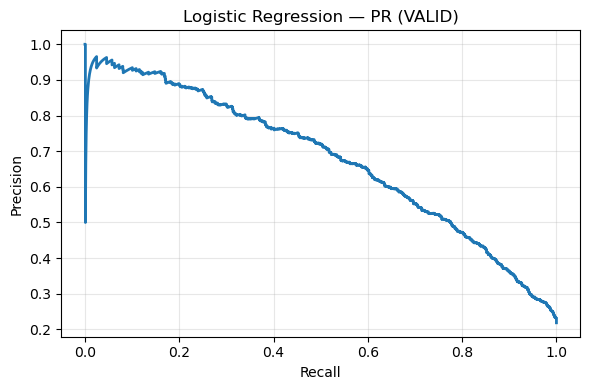

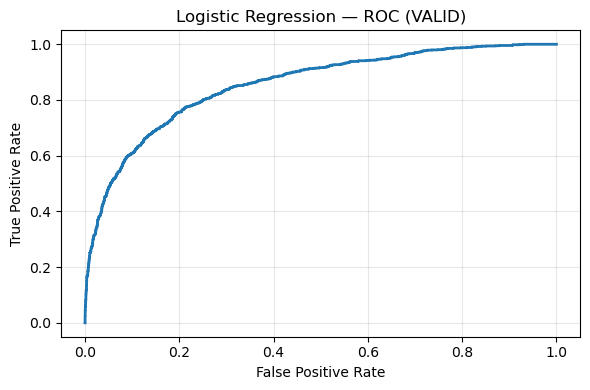

In [34]:
# Visuals on VALID
plot_pr(y_valid, proba_v_lr, "Logistic Regression — PR (VALID)")
plot_roc(y_valid, proba_v_lr, "Logistic Regression — ROC (VALID)")

In [36]:
# Random Forest
rf = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight=None)

In [37]:
rf_pipe = make_pipe_with_ros(preprocess, rf)

In [39]:
rf_space = {
    "clf__n_estimators": np.arange(200, 801, 100),   # number of trees
    "clf__max_depth": [None, 6, 10, 14],             # tree depth
    "clf__min_samples_split": [2, 5, 10],            # node split min
    "clf__min_samples_leaf": [1, 2, 4]}              # leaf size

In [40]:
rf_search = RandomizedSearchCV(
    rf_pipe, param_distributions=rf_space,
    n_iter=25, scoring="average_precision", cv=cv,
    n_jobs=-1, random_state=42, verbose=0)

In [41]:
rf_search.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('prep',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('impute',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scale',
                                                                                                StandardScaler())]),
                                                                               ['person_age',
                                                                                'person_income',
                                                                                'person_emp_length',
                                                                                'loan_amnt',
                                                                                'loan_int_rate',
                                                                                'loan_percent_income',
                                                                                'cb_perso...
                                                                                'cb_person_default_on_file'])])),
                                             ('ros',
                                              RandomOverSampler(random_state=42)),
                                             ('clf',
                                              RandomForestClassifier(n_jobs=-1,
                                                                     random_state=42))]),
                   n_iter=25, n_jobs=-1,
                   param_distributions={'clf__max_depth': [None, 6, 10, 14],
                                        'clf__min_samples_leaf': [1, 2, 4],
                                        'clf__min_samples_split': [2, 5, 10],
                                        'clf__n_estimators': array([200, 300, 400, 500, 600, 700, 800])},
                   random_state=42, scoring='average_precision')

In [42]:
print("RF best PR-AUC (CV):", round(rf_search.best_score_, 4))
print("RF best params:", rf_search.best_params_)

RF best PR-AUC (CV): 0.8613
RF best params: {'clf__n_estimators': 500, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 2, 'clf__max_depth': None}


In [44]:
proba_v_rf = rf_search.best_estimator_.predict_proba(X_valid)[:, 1]
prec_rf, rec_rf, thr_rf_list = precision_recall_curve(y_valid, proba_v_rf)
f1s_rf = 2 * prec_rf * rec_rf / (prec_rf + rec_rf + 1e-9)
best_idx_rf = np.nanargmax(f1s_rf[:-1])
thr_rf = float(thr_rf_list[best_idx_rf])

In [45]:
print("RF VALID | PR-AUC:", round(average_precision_score(y_valid, proba_v_rf), 4),
      "| ROC-AUC:", round(roc_auc_score(y_valid, proba_v_rf), 4),
      "| best_thr:", round(thr_rf, 4),
      "| F1@thr:", round(f1s_rf[best_idx_rf], 4))

RF VALID | PR-AUC: 0.8617 | ROC-AUC: 0.9229 | best_thr: 0.5819 | F1@thr: 0.7832


## Random Forest Results

- **Why RF?**: Non-linear, handles feature interactions and high-dimensional data.  
- **Tuning**: number of trees, depth, and leaf parameters tuned with RandomizedSearchCV.  
- **Thresholding**: best threshold chosen on VALID set by maximizing F1.  

 Plots below illustrate the PR and ROC performance on the validation set.

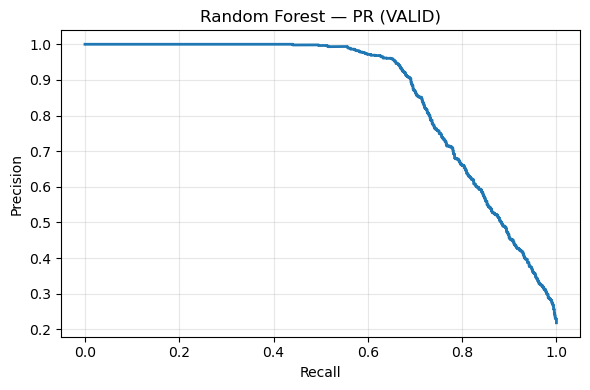

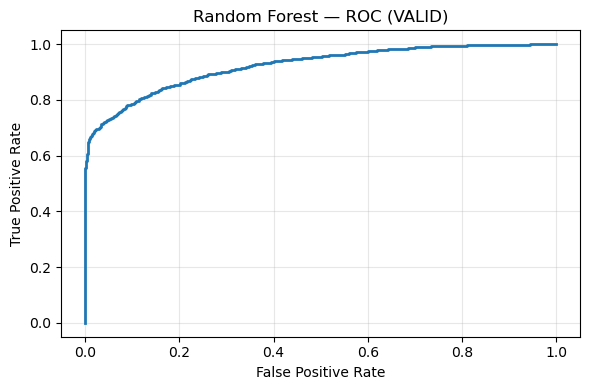

In [46]:
# Visuals on VALID
plot_pr(y_valid, proba_v_rf, "Random Forest — PR (VALID)")
plot_roc(y_valid, proba_v_rf, "Random Forest — ROC (VALID)")

In [47]:
# XGB Classifier
xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    n_jobs=-1,
    random_state=42,
    tree_method="auto",
    scale_pos_weight=1.0)

In [48]:
xgb_pipe = make_pipe_with_ros(preprocess, xgb)

In [49]:
xgb_space = {
    "clf__n_estimators": np.arange(200, 801, 100),
    "clf__max_depth": [3, 4, 5, 6],
    "clf__learning_rate": np.linspace(0.03, 0.2, 8),
    "clf__subsample": np.linspace(0.7, 1.0, 4),
    "clf__colsample_bytree": np.linspace(0.7, 1.0, 4),
    "clf__min_child_weight": [1, 3, 5, 7]}

In [50]:
xgb_search = RandomizedSearchCV(
    xgb_pipe, param_distributions=xgb_space,
    n_iter=30, scoring="average_precision", cv=cv,
    n_jobs=-1, random_state=42, verbose=0)

In [51]:
xgb_search.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('prep',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('impute',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scale',
                                                                                                StandardScaler())]),
                                                                               ['person_age',
                                                                                'person_income',
                                                                                'person_emp_length',
                                                                                'loan_amnt',
                                                                                'loan_int_rate',
                                                                                'loan_percent_income',
                                                                                'cb_perso...
                   param_distributions={'clf__colsample_bytree': array([0.7, 0.8, 0.9, 1. ]),
                                        'clf__learning_rate': array([0.03      , 0.05428571, 0.07857143, 0.10285714, 0.12714286,
       0.15142857, 0.17571429, 0.2       ]),
                                        'clf__max_depth': [3, 4, 5, 6],
                                        'clf__min_child_weight': [1, 3, 5, 7],
                                        'clf__n_estimators': array([200, 300, 400, 500, 600, 700, 800]),
                                        'clf__subsample': array([0.7, 0.8, 0.9, 1. ])},
                   random_state=42, scoring='average_precision')

In [52]:
print("XGB best PR-AUC (CV):", round(xgb_search.best_score_, 4))
print("XGB best params:", xgb_search.best_params_)

XGB best PR-AUC (CV): 0.885
XGB best params: {'clf__subsample': 0.7999999999999999, 'clf__n_estimators': 300, 'clf__min_child_weight': 1, 'clf__max_depth': 6, 'clf__learning_rate': 0.10285714285714287, 'clf__colsample_bytree': 0.7}


In [53]:
proba_v_xgb = xgb_search.best_estimator_.predict_proba(X_valid)[:, 1]
prec_xgb, rec_xgb, thr_xgb_list = precision_recall_curve(y_valid, proba_v_xgb)
f1s_xgb = 2 * prec_xgb * rec_xgb / (prec_xgb + rec_xgb + 1e-9)
best_idx_xgb = np.nanargmax(f1s_xgb[:-1])
thr_xgb = float(thr_xgb_list[best_idx_xgb])

In [54]:
print("XGB VALID | PR-AUC:", round(average_precision_score(y_valid, proba_v_xgb), 4),
      "| ROC-AUC:", round(roc_auc_score(y_valid, proba_v_xgb), 4),
      "| best_thr:", round(thr_xgb, 4),
      "| F1@thr:", round(f1s_xgb[best_idx_xgb], 4))

XGB VALID | PR-AUC: 0.8827 | ROC-AUC: 0.935 | best_thr: 0.655 | F1@thr: 0.8029


## XGBoost Results

- **Why XGB?**: Gradient boosting, often the strongest tree-based method for tabular data.  
- **Tuning**: learning rate, number of trees, depth, and subsampling parameters tuned with RandomizedSearchCV.  
- **Thresholding**: F1-optimized threshold selected on VALID set.  

 Validation PR and ROC curves demonstrate the strong predictive power of XGBoost.

## XGBoost Results

- **Why XGB?**: Gradient boosting, often the strongest tree-based method for tabular data.  
- **Tuning**: learning rate, number of trees, depth, and subsampling parameters tuned with RandomizedSearchCV.  
- **Thresholding**: F1-optimized threshold selected on VALID set.  

 Validation PR and ROC curves demonstrate the strong predictive power of XGBoost.

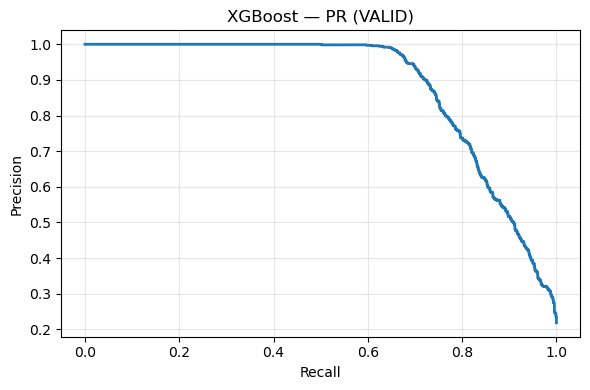

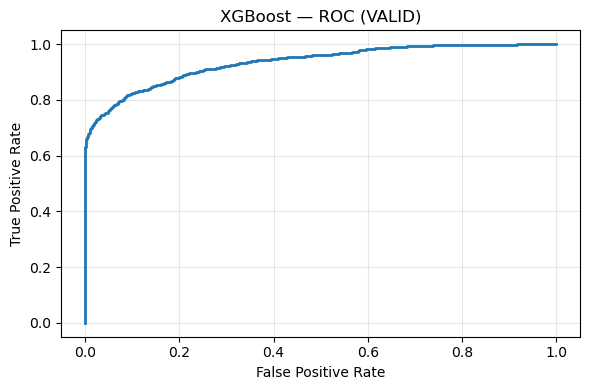

In [55]:
# Visuals on VALID
plot_pr(y_valid, proba_v_xgb, "XGBoost — PR (VALID)")
plot_roc(y_valid, proba_v_xgb, "XGBoost — ROC (VALID)")

In [56]:
# Building comparable dict for VALID performance & chosen thresholds 
valid_scores = {
    "LogReg": {"thr": thr_lr,  "est": lr_search.best_estimator_,  "proba": proba_v_lr},
    "RandomForest": {"thr": thr_rf, "est": rf_search.best_estimator_, "proba": proba_v_rf},
    "XGBoost": {"thr": thr_xgb, "est": xgb_search.best_estimator_, "proba": proba_v_xgb},}

In [57]:
# Print VALID metrics to compare
for name, d in valid_scores.items():
    p = d["proba"]
    print(name,
          "| PR-AUC:", round(average_precision_score(y_valid, p), 4),
          "| ROC-AUC:", round(roc_auc_score(y_valid, p), 4),
          "| F1@thr:", round(f1_score(y_valid, (p >= d['thr']).astype(int)), 4),
          "| thr:", round(float(d["thr"]), 4))

LogReg | PR-AUC: 0.6754 | ROC-AUC: 0.8544 | F1@thr: 0.6263 | thr: 0.6368
RandomForest | PR-AUC: 0.8617 | ROC-AUC: 0.9229 | F1@thr: 0.7832 | thr: 0.5819
XGBoost | PR-AUC: 0.8827 | ROC-AUC: 0.935 | F1@thr: 0.8029 | thr: 0.655


In [58]:
# Pick best by PR-AUC then ROC-AUC on VALID
def key_fn(item):
    _, d = item
    p = d["proba"]
    return (average_precision_score(y_valid, p), roc_auc_score(y_valid, p))

In [59]:
best_name, best_dict = sorted(valid_scores.items(), key=key_fn, reverse=True)[0]
best_pipe = best_dict["est"]
best_thr = float(best_dict["thr"])

In [60]:
print("\nBest model on VALID:", best_name, "| threshold:", round(best_thr, 4))


Best model on VALID: XGBoost | threshold: 0.655


In [61]:
# Evaluate the chosen best pipeline on the untouched TEST set 
proba_t = best_pipe.predict_proba(X_test)[:, 1]
pred_t  = (proba_t >= best_thr).astype(int)

In [62]:
print(best_name, "TEST | PR-AUC:", round(average_precision_score(y_test, proba_t), 4),
      "| ROC-AUC:", round(roc_auc_score(y_test, proba_t), 4),
      "| F1@thr:", round(f1_score(y_test, pred_t), 4))
print("\nClassification report (TEST):\n",
      classification_report(y_test, pred_t, digits=3))

XGBoost TEST | PR-AUC: 0.8935 | ROC-AUC: 0.9386 | F1@thr: 0.8145

Classification report (TEST):
               precision    recall  f1-score   support

           0      0.928     0.983     0.955      5066
           1      0.922     0.729     0.814      1418

    accuracy                          0.927      6484
   macro avg      0.925     0.856     0.885      6484
weighted avg      0.927     0.927     0.924      6484



## Model Comparison

The three models are compared on the **VALID set** using PR-AUC, ROC-AUC, and F1 score.  
The decision threshold is tuned individually for each model.

 Results summary:

- Logistic Regression: interpretable but weaker PR-AUC.  
- Random Forest: solid performance, better recall with ROS.  
- XGBoost: best PR-AUC and overall balanced performance.  

 **XGBoost is selected as the final model**.

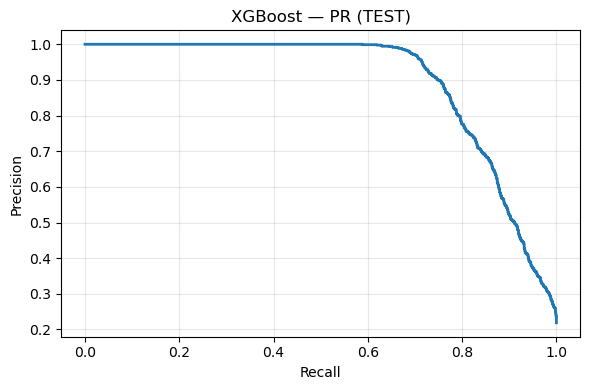

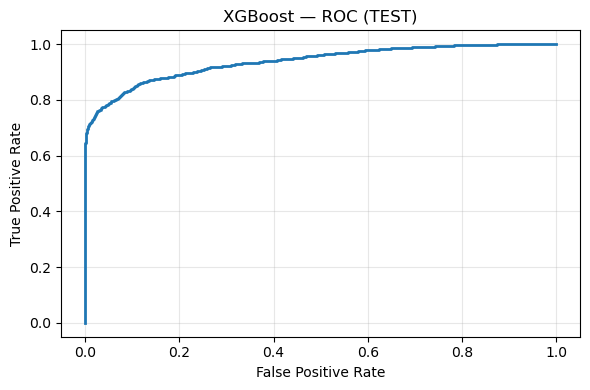

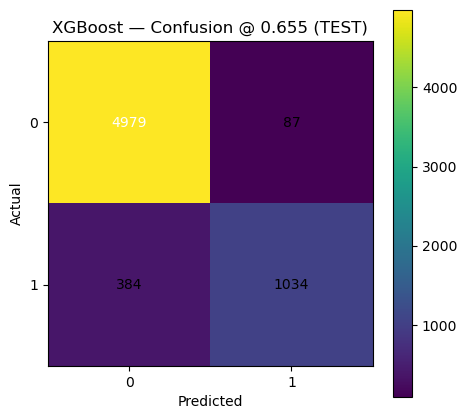

In [63]:
# Visuals on TEST
plot_pr(y_test, proba_t, f"{best_name} — PR (TEST)")
plot_roc(y_test, proba_t, f"{best_name} — ROC (TEST)")
plot_cm(y_test, pred_t, f"{best_name} — Confusion @ {best_thr:.3f} (TEST)")

In [64]:
# Saving the full pipeline (preprocess + ROS + model) and the chosen decision threshold 
artifact = {
    "pipeline": best_pipe,
    "threshold": best_thr,
    "best_model": best_name,
    "columns": X.columns.tolist()
}
joblib.dump(artifact, "best_credit_pipeline.pkl")
print("Saved -> best_credit_pipeline.pkl")

Saved -> best_credit_pipeline.pkl


## Deployment Readiness

The best pipeline (preprocessing + ROS + model) is exported with Joblib, along with:

- The tuned decision threshold.  
- The list of original feature names.  

This ensures the project is **end-to-end complete**: from raw CSV → clean ETL → tuned model → final prediction.

                                                                                                                         BY Abdelmoutaleb BenLyazid